In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import scipy.optimize as opt

In [9]:
#making a first order CSTR for E. Coli decay

In [2]:
Ea = 84900
R = 8.314
k0 = 2.83e13
def ktemp(T):
    return k0 * np.exp(-Ea / (R * T))

In [3]:
def knatural(T): #this is just natural decay
    k_nat = 0.37 #1/day
    Tref = 293 #K
    thetan = 0.951
    knatT = k_nat * (thetan**(T-Tref))
    return knatT/(24*60)

In [4]:
def ksolar(I, T): #how UV impacts decay
    k_sol = 1.8
    thetas = 1
    Tref = 293
    Icon = I*(86400/1e6)
    ksT = k_sol*(thetas**(T-Tref))
    ksolday = ksT*Icon
    return ksolday/(24*60)

In [5]:
def kpred(D,T): #filter feeders
    kp = 0.020
    thetap = 1
    Tref = 293
    kpT = kp*(thetap**(T-Tref))
    kpday = kpT*D
    return kpday /(24*60)

In [6]:
def cstrall(c, t, Q, V, c0, T, Isol, Ddap):
    knat = knatural(T)
    ksol = ksolar(Isol, T)
    kpr = kpred(Ddap, T)
    
    ktot = knat + ksol + kpr
    
    dcdt = (Q/V)*(c0-c) - ktot*c
    return dcdt

#initial parameters
V = 1000 
Q = 10 
c0 = 1.7e6
T = 298 #initial values from paper Hernandez-Crespo
Isol = 800
Ddap = 10

tau = V/Q
knat = knatural(T)
ksol = ksolar(Isol, T)
kpr = kpred(Ddap, T)
ktot = knat + ksol + kpr

c_ss = c0 / (1 + ktot * tau)

In [7]:
time = np.linspace(0, 300, 100)
cinit = 0
csol = odeint(cstrall, cinit, time, args=(Q,V,c0,T,Isol, Ddap))

Text(0, 0.5, 'concentration')

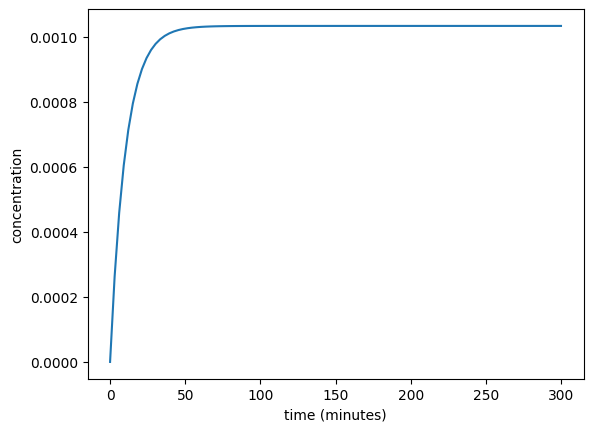

In [8]:
plt.plot(time, csol/(c0*100))
plt.xlabel('time (minutes)')
plt.ylabel('concentration')